# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
# !pip install scikit-learn matplotlib Pillow
# !pip install tensorflow
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
# Basic Imports
import os
import sys
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg

# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE

from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense
import keras
from keras import optimizers
import sklearn 

plt.ion()
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [14]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

In [15]:
# Loading the dataset
# eg.
dirpath = './dataset/IMFDB/'
X1,y1 = load_data(dirpath)
N1,H1,W1 = X1.shape[0:3]
C1 = 1 if opt['is_grayscale'] else X1.shape[3]
dirpath = './dataset/Yale_face_database/'
X2,y2 = load_data(dirpath)
N2,H2,W2 = X2.shape[0:3]
C2 = 1 if opt['is_grayscale'] else X2.shape[3]
dirpath = './dataset/IIIT-CFW/'
X3,y3 = load_data(dirpath)
N3,H3,W3 = X3.shape[0:3]
C3 = 1 if opt['is_grayscale'] else X3.shape[3]

Dataset shape: (400, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)


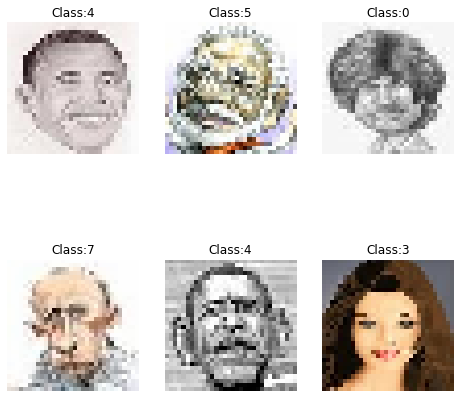

In [16]:
# Show sample images
X=X3
y=y3
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [17]:
# Flatten to apply PCA/LDA
X1 = X1.reshape((N1,H1*W1*C1))
X2 = X2.reshape((N2,H2*W2*C2))
X3 = X3.reshape((N3,H3*W3*C3))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [18]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    return pca,X_k

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [19]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [20]:
def get_lda(X,y, k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [24]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X_transformed,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [25]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [26]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Your answers here (double click to edit)


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [27]:
# Compute your features 
# eg.
X_3D = get_kernel_lda(X1,y1,3)
# X_temp=get_vgg_features('./dataset/IMFDB')
# X_temp.shape
# X_temp=get_resnet_features('./dataset/IMFDB')
# X_temp.shape

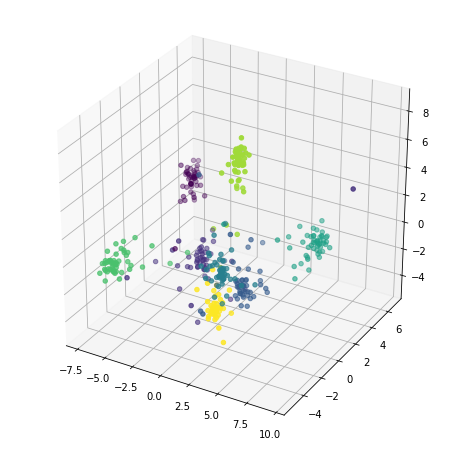

In [28]:
# Create a scatter plot  
# eg.
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_3D[:,0],X_3D[:,1],X_3D[:,2],c=y1)
# print(X1.shape)
# print(X2.shape)
# print(X3.shape)

123


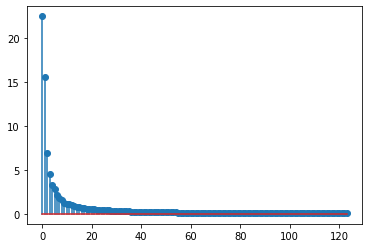

308


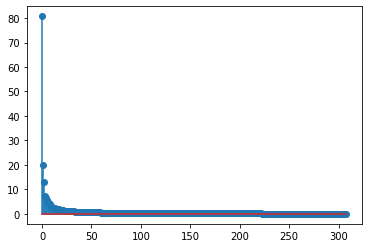

61


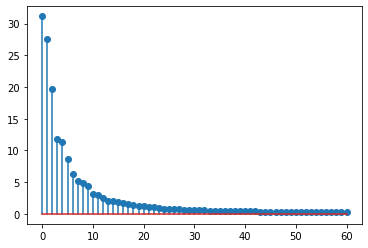

In [76]:
# Plot the eigen value spectrum 
cov1=np.cov(np.transpose(X1))
v1,e1=np.linalg.eig(cov1)
sum=0
size=opt['image_size']
for i in range(size*size*3):
    sum+=v1[i]
ind1=0
curr=0
for i in range(size*size*3):
    curr+=v1[i]
    ind1=i
    if(curr>0.95*sum):break
pca1,X_k1=get_pca(X1,ind1+1)
print(ind1)
plt.stem(v1[0:ind1+1])
plt.show()
cov3=np.cov(np.transpose(X3))
v3,e3=np.linalg.eig(cov3)
sum=0
size=opt['image_size']
for i in range(size*size*3):
    sum+=v3[i]
ind3=0
curr=0
for i in range(size*size*3):
    curr+=v3[i]
    ind3=i
    if(curr>0.95*sum):break
pca3,X_k3=get_pca(X3,ind3+1)
print(ind3)
plt.stem(v3[0:ind3+1])
plt.show()
cov2=np.cov(np.transpose(X2))
v2,e2=np.linalg.eig(cov2)
sum=0
size=opt['image_size']
for i in range(size*size*3):
    sum+=v2[i]
ind2=0
curr=0
for i in range(size*size*3):
    curr+=v2[i]
    ind2=i
    if(curr>0.95*sum):break
pca2,X_k2=get_pca(X2,ind2+1)
print(ind2)
plt.stem(v2[0:ind2])
plt.show()

1(c). Reconstruct  the  image  back for each case


In [83]:
def reconstruct_images(X_k,pca):
    """
        Reconstruct the images back by just using the selected principal components. 


        You have to write the code in this code block.
        You can change the functions provided above (eg, get_pca, get_lda) for your use case. 
            
        @params: 
                Input parameters

        @return reconstructed_X => reconstructed image
        
    """
    
    reconstruct_X = pca.inverse_transform(X_k)
    size=opt['image_size']
    reconstruct_X = np.reshape(reconstruct_X,(X_k.shape[0],size,size,3))
    return reconstruct_X    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


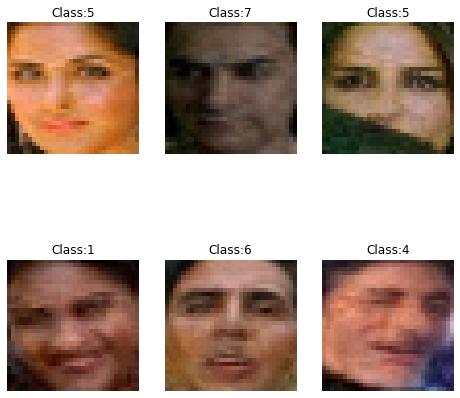

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.03856743483611854


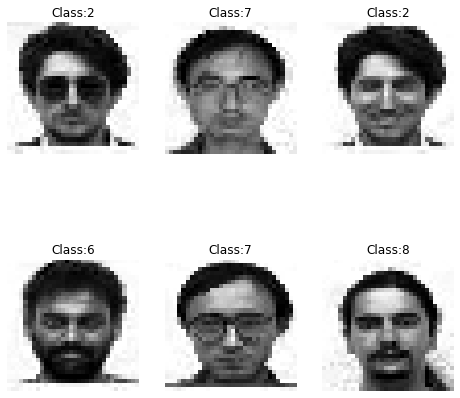

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.05379278356559667


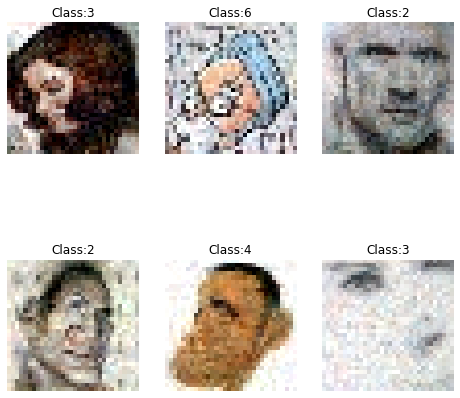

0.06813534117722074


In [84]:
# Display results 
X_reconstruced1 = reconstruct_images(X_k1,pca1)
X_reconstruced2 = reconstruct_images(X_k2,pca2)
X_reconstruced3 = reconstruct_images(X_k3,pca3)
# Display random images
ind = np.random.randint(0,y1.shape[0],6)
disply_images(X_reconstruced1[ind,...],y1[ind],row=2,col=3)

# Show the reconstruction error
X_reconstruced1=np.reshape(X_reconstruced1,(X1.shape[0],X1.shape[1]))
print(np.sqrt(np.mean((X1 - X_reconstruced1)**2)))

ind = np.random.randint(0,y2.shape[0],6)
disply_images(X_reconstruced2[ind,...],y2[ind],row=2,col=3)

# Show the reconstruction error
X_reconstruced2=np.reshape(X_reconstruced2,(X2.shape[0],X2.shape[1]))
print(np.sqrt(np.mean((X2 - X_reconstruced2)**2)))

ind = np.random.randint(0,y3.shape[0],6)
disply_images(X_reconstruced3[ind,...],y3[ind],row=2,col=3)

# Show the reconstruction error
X_reconstruced3=np.reshape(X_reconstruced3,(X3.shape[0],X3.shape[1]))
print(np.sqrt(np.mean((X3 - X_reconstruced3)**2)))

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

In [85]:
# code goes here
errors = np.zeros(8)
X=[X1,X2,X3]
y=[y1,y2,y3]
for i in range(8):
    errors[i] = np.sqrt(np.mean((X1[y1==i,:] - X_reconstruced1[y1==i,:])**2))
idx = np.argmax(errors)
print(list(imfdb_dict.keys())[idx],"has the highest reconstruction error")
errors = np.zeros(15)
X=[X1,X2,X3]
y=[y1,y2,y3]
for i in range(15):
    errors[i] = np.sqrt(np.mean((X2[y2==i,:] - X_reconstruced2[y2==i,:])**2))
idx = np.argmax(errors)
print(idx,"has the highest reconstruction error")
errors = np.zeros(8)
X=[X1,X2,X3]
y=[y1,y2,y3]
for i in range(8):
    errors[i] = np.sqrt(np.mean((X3[y3==i,:] - X_reconstruced3[y3==i,:])**2))
idx = np.argmax(errors)
print(list(cfw_dict.keys())[idx],"has the highest reconstruction error")

SharukhKhan has the highest reconstruction error
0 has the highest reconstruction error
AamirKhan has the highest reconstruction error


2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [86]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.svm import SVC,LinearSVR
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix as confMat
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score
class Classifier():
    def __init__(self,hidden_layer_size = (100,50,25)):
#         super.__init__()
        self.model = MLPClassifier(hidden_layer_sizes=hidden_layer_size,max_iter=10000,activation='relu',solver='adam') 
    
    def classify(self,X):
        prediction=self.model.predict(X)
        return prediction
        
    def confusion_matrix(self,pred,y):
        pred  = sklearn.metrics.confusion_matrix(y, pred, labels=None, sample_weight=None)
        return pred    
    def train(self,X_train,y_train):
        self.model.fit(X_train, y_train)
        
    def validate(self,X_validate,y_validate):
        pred = self.classify(X_validate)
        conf=self.confusion_matrix(pred,y_validate)
        val_acc = accuracy_score(y_validate,pred,normalize = True)
        precision = precision_score(y_validate,pred,average = 'macro')
        recall = recall_score(y_validate,pred,average = 'macro')
        f1 = f1_score(y_validate,pred,average = 'macro')
    
        return val_acc,precision,recall,f1,conf

In [87]:
# Create a train and validation split to train your classifier 
from sklearn.preprocessing import MinMaxScaler,StandardScaler
# sc = StandardScaler()
# X_train =sc.fit_transform(X_train)
# X_test = sc.transform(X_test)
dirpath = ['./dataset/IMFDB/','./dataset/Yale_face_database/','./dataset/IIIT-CFW/']
def get_feature(x,y,k,j):
#     k=128
    _,x_k1= get_pca(x,k)
    X_train1,X_test1,y_train1,y_test1 = sklearn.model_selection.train_test_split(x_k1,y,test_size = 0.2)
    x_k1= get_lda(x,y,k)
#     print(x_k1.shape)
    X_train2,X_test2,y_train2,y_test2 = sklearn.model_selection.train_test_split(x_k1,y,test_size = 0.2)
    x_k1= get_kernel_pca(x,k)
    X_train3,X_test3,y_train3,y_test3 = sklearn.model_selection.train_test_split(x_k1,y,test_size = 0.2)
    x_k1= get_kernel_lda(x,y,k)
    X_train4,X_test4,y_train4,y_test4 = sklearn.model_selection.train_test_split(x_k1,y,test_size = 0.2)
    if(j<3):
        x_k1= get_vgg_features(dirpath[j])
        X_train5,X_test5,y_train5,y_test5 = sklearn.model_selection.train_test_split(x_k1,y,test_size = 0.2)
        x_k1= get_resnet_features(dirpath[j])
        X_train6,X_test6,y_train6,y_test6 = sklearn.model_selection.train_test_split(x_k1,y,test_size = 0.2)
    else:
        X_train5,X_test5,y_train5,y_test5 =[],[],[],[]
        X_train6,X_test6,y_train6,y_test6 =[],[],[],[] 
    X_train=[X_train1,X_train2,X_train3,X_train4,X_train5,X_train6]
    Y_train=[y_train1,y_train2,y_train3,y_train4,y_train5,y_train6]
    Y_test=[y_test1,y_test2,y_test3,y_test4,y_test5,y_test6]
    X_test=[X_test1,X_test2,X_test3,X_test4,X_test5,X_test6]
    return X_train,X_test,Y_train,Y_test
# X_test4= get_kernel_lda(X_test,y_test,k)

In [88]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score
# Print the table. (You can use Pandas)
# dirpath = './dataset/IIIT-CFW/'
D=[X1,X2,X3]
L=[y1,y2,y3]
names=['IMFDB','Yale','CFW']
feature_list = ['PCA','LDA','KPCA','KLDA','VGG','RESNET']
ind=[ind1,ind2,ind3]
best={}
for  j in range(3):
    X_train,X_test,Y_train,Y_test=get_feature(D[j],L[j],ind[j],j)
    acc = np.zeros(6)
    f1 = np.zeros(6)
    re=np.zeros(6)
    conf={}
    for i in range(6):
        obj  = Classifier()
        obj.train(X_train[i],Y_train[i])
        acc[i],_,_,f1[i],co = obj.validate(X_test[i],Y_test[i])
        re[i]=X_train[i].shape[1]
        conf[i]=co
    acc=100*acc
    err=100-acc
    print('\n'+names[j])
    df = pd.DataFrame({
        'Method' : pd.Categorical(feature_list[0:6]),
        'Reduced Space' : re ,
        'Classification error' :err ,
        'Accuracy' : acc ,
        'f1-score' : f1 })
    display(df)
    req=np.argmax(acc)
    best[j]=conf[req]


IMFDB


,Method,Reduced Space,Classification error,Accuracy,f1-score
0,PCA,123.0,22.50,77.50,0.783950
1,LDA,7.0,3.75,96.25,0.961960
2,KPCA,123.0,30.00,70.00,0.686567
3,KLDA,7.0,10.00,90.00,0.892702
4,VGG,4096.0,7.50,92.50,0.923034
5,RESNET,2048.0,3.75,96.25,0.954731



Yale


,Method,Reduced Space,Classification error,Accuracy,f1-score
0,PCA,61.0,15.151515,84.848485,0.792687
1,LDA,14.0,0.000000,100.000000,1.000000
2,KPCA,61.0,30.303030,69.696970,0.546939
3,KLDA,14.0,0.000000,100.000000,1.000000
4,VGG,4096.0,51.515152,48.484848,0.492222
5,RESNET,2048.0,0.000000,100.000000,1.000000



CFW


,Method,Reduced Space,Classification error,Accuracy,f1-score
0,PCA,308.0,49.629630,50.370370,0.495562
1,LDA,7.0,4.444444,95.555556,0.953821
2,KPCA,308.0,51.111111,48.888889,0.447925
3,KLDA,7.0,2.222222,97.777778,0.976339
4,VGG,4096.0,30.370370,69.629630,0.683849
5,RESNET,2048.0,2.222222,97.777778,0.973833


In [89]:
# For each dataset print the confusion matrix for the best model 
for i in range(3):
    print('\n'+names[i])
    print(best[i])


IMFDB
[[11  0  0  0  0  0  0  0]
 [ 1  8  0  0  0  0  0  0]
 [ 0  1 10  0  0  0  0  0]
 [ 0  0  0 11  0  0  0  0]
 [ 0  0  0  0 10  0  0  0]
 [ 0  0  0  0  0  9  0  0]
 [ 0  0  0  0  0  0 10  0]
 [ 0  0  1  0  0  0  0  8]]

Yale
[[3 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 3 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 2 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 2 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 3 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 2 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 2 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 2]]

CFW
[[ 7  0  0  0  0  1  0  0]
 [ 0  7  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0]
 [ 0  0  0 18  0  0  0  0]
 [ 0  0  0  0 26  0  0  0]
 [ 0  0  0  0  0 15  1  0]
 [ 0  0  0  0  0  0 28  0]
 [ 0  0  0  0  0  0  1 19]]


3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [ ]:
# Compute TSNE for different features and create a scatter plot
k = 2


D=[X1,X2,X3]
L=[y1,y2,y3]
names=['IMFDB','Yale','CFW']
ind=[ind1,ind2,ind3]
best={}
for  j in range(3):
    X_train,X_test,Y_train,Y_test=get_feature(D[j],L[j],ind[j],j)
    for i in range(6):
        X_TSNE = TSNE(n_components=k).fit_transform(X_train[i])
        if(k==2):
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111)
            ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=Y_train[i])
        elif(k==3):
            fig = plt.figure(figsize=(8,8))
            ax = fig.add_subplot(111,projection='3d')
            ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=Y_train[i])


4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [90]:
from sklearn.neighbors import KNeighborsClassifier as knn
class FaceVerification():
    def __init__(self,k):
#         super.__init__()
        self.n_neighbors = k
        self.model = knn(n_neighbors = self.n_neighbors)
    
    def verify(self,X,class_id):
        pred = self.model.predict(X)
        verification_results = (pred == class_id)
        return verification_results
        
    def train(self,X_train,y_train):
        self.model.fit(X_train,y_train)
    
    def validate(self,X_validate,y_validate):
        results=self.verify(X_validate,y_validate)
        acc = np.sum(results)/results.shape
        precision =precision_score(y_validate,self.model.predict(X_validate),average = 'macro')
        return acc,precision

In [ ]:
# Create a train and validation split and show your results 
#splitting done in get_feature function below

In [62]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

# Print the table. (You can use Pandas)
D=[X1,X2,X3]
L=[y1,y2,y3]
names=['IMFDB','Yale','CFW']
feature_list = ['PCA','LDA','KPCA','KLDA','VGG','RESNET']
ind=[ind1,ind2,ind3]
accuracy=[]
precision=[]
for  j in range(3):
    X_train,X_test,Y_train,Y_test=get_feature(D[j],L[j],ind[j],j)
    acc = np.zeros(6)
    pre=np.zeros(6)
    for i in range(6):
        obj  = FaceVerification(20)
        obj.train(X_train[i],Y_train[i])
        acc[i],pre[i] = obj.validate(X_test[i],Y_test[i])
    acc=100*acc
    err=100-acc
    print('\n'+names[j])
    df = pd.DataFrame({
        'Method' : pd.Categorical(feature_list[0:6]),
#         'Reduced Space' : k_array ,
        'verification error' : err ,
        'Accuracy' : acc ,
        'precision' : pre })
    print(df)


IMFDB
   Method  verification error  Accuracy  precision
0     PCA               52.50     47.50   0.632119
1     LDA                2.50     97.50   0.974760
2    KPCA               46.25     53.75   0.601194
3    KLDA                5.00     95.00   0.953314
4     VGG               10.00     90.00   0.905754
5  RESNET                5.00     95.00   0.960606

Yale
   Method  verification error   Accuracy  precision
0     PCA           48.484848  51.515152   0.588889
1     LDA           24.242424  75.757576   0.728938
2    KPCA           57.575758  42.424242   0.478571
3    KLDA           33.333333  66.666667   0.645408
4     VGG           51.515152  48.484848   0.550000
5  RESNET            9.090909  90.909091   0.863095

CFW
   Method  verification error   Accuracy  precision
0     PCA           70.370370  29.629630   0.525603
1     LDA            3.703704  96.296296   0.958282
2    KPCA           67.407407  32.592593   0.502640
3    KLDA            3.703704  96.296296   0.954716
4


PCA


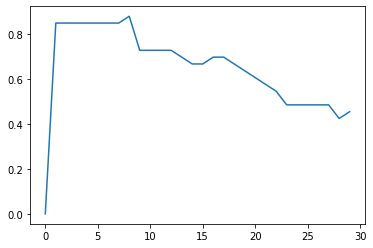

LDA


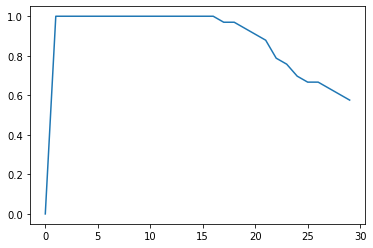

KPCA


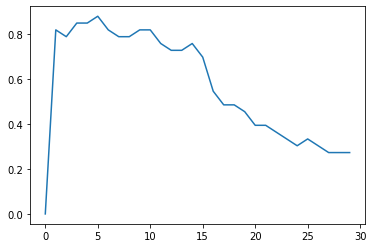

KLDA


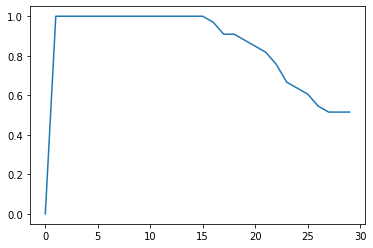

VGG


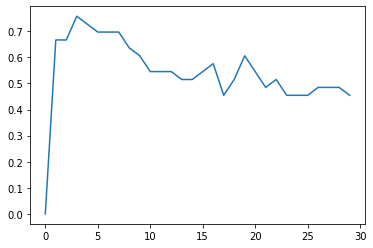

RESNET


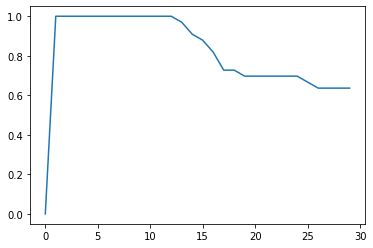

In [92]:
for j in range(1):
    X_train,X_test,Y_train,Y_test=get_feature(D[j+1],L[j+1],ind[j+1],j+1)
    print("")
    for i in range(6):
        acc = np.zeros(30)
        pre=np.zeros(30)
        for k in range(1,30):
            obj  = FaceVerification(k)
            obj.train(X_train[i],Y_train[i])
            acc[k],pre[k] = obj.validate(X_test[i],Y_test[i])
#         acc=100*acc
#         err=100-acc
        x=np.zeros(20)
        print(feature_list[i])
        plt.plot(acc)
#         plt.plot(pre)
        plt.show()

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

Label 0 corresponds to cartoon and Label 1 corresponds to real images



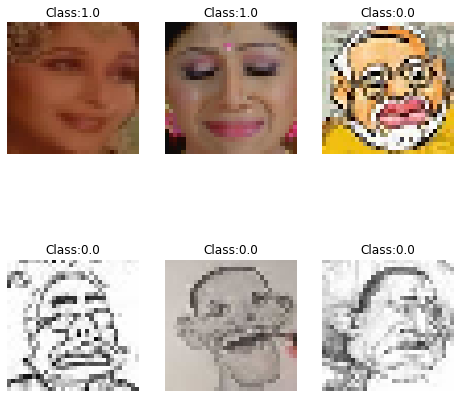

In [96]:
# Load data
X_temp_3=X3[np.random.choice(len(X3), size=400, replace=False)]
cfw=X_temp_3
new_labels=list(np.zeros(cfw.shape[0]))
imf=X1
new_data=np.concatenate((cfw,imf)) 
new_labels=new_labels+list(np.ones(imf.shape[0]))
new_data=np.array(new_data)
new_labels=np.array(new_labels)
X_new=new_data
y_new=new_labels
# print(X_new.shape)
# print(y_new.shape)
print("Label 0 corresponds to cartoon and Label 1 corresponds to real images",end='\n\n')
X_new_re=np.reshape(X_new,(800,32,32,3))
ind = np.random.randint(0,y_new.shape[0],6)
disply_images(X_new_re[ind,...],y_new[ind],row=2,col=3)

In [97]:
# Define your features
X_train,X_test,Y_train,Y_test=get_feature(X_new,y_new,120,5)

In [98]:
# Create your classifier

# Validate your classifier
acc =np.zeros(4)
f1 = np.zeros(4)
re= np.zeros(4)
conf={}
wrong=[]
pred1=[]
actual1=[]

for i in range(4):
    obj  = Classifier()
    obj.train(X_train[i],Y_train[i])
    acc[i],_,_,f1[i],co = obj.validate(X_test[i],Y_test[i])
    re[i]=X_train[i].shape[1]
    conf[i]=co
#     if(i==0):
#         print(pred,'\n\n\n',Y_train[i])
acc=100*acc
err=100-acc



NEW DATA SET
  Method  Reduced Space  Classification error  Accuracy  f1-score
0    PCA          120.0                 2.500    97.500  0.974937
1    LDA            1.0                 0.000   100.000  1.000000
2   KPCA          120.0                 1.250    98.750  0.987469
3   KLDA            1.0                 0.625    99.375  0.993695


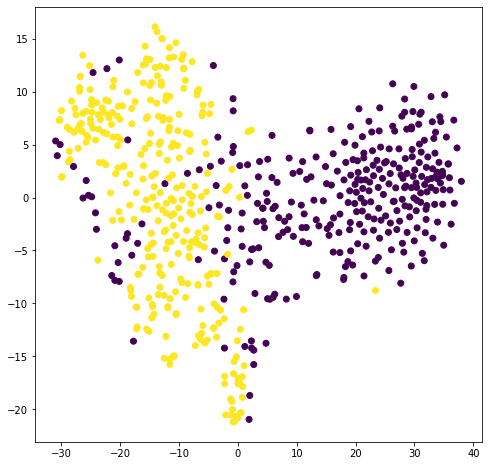

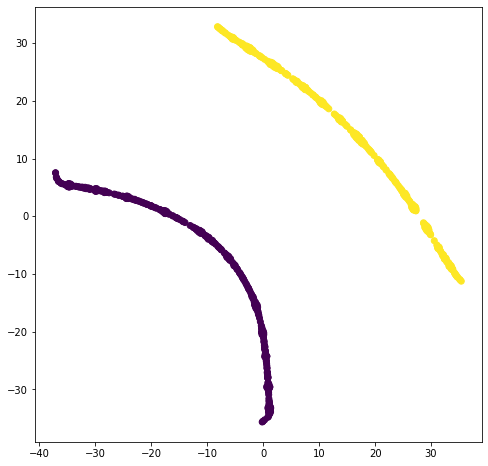

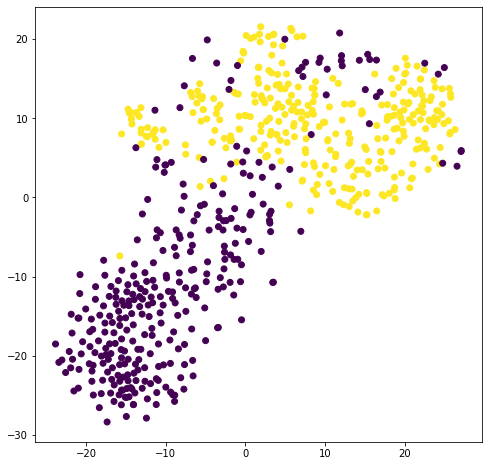

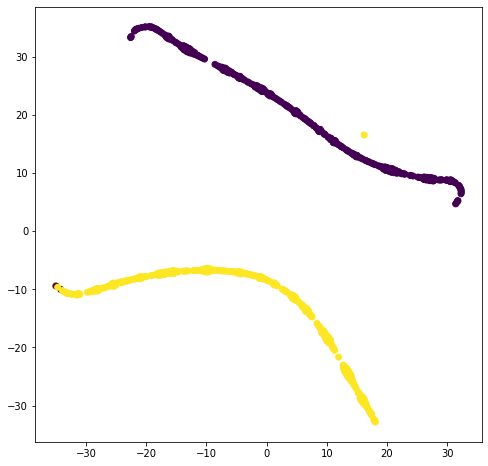

In [99]:
# Show qualitative results such as accuracy, k-fold validation, TSNE/PCA/Isomap plots, etc.
print('NEW DATA SET')
df = pd.DataFrame({
    'Method' : pd.Categorical(feature_list[0:4]),
    'Reduced Space' : re ,
    'Classification error' :err ,
    'Accuracy' : acc ,
    'f1-score' : f1 })
print(df)
req=np.argmax(acc)
best[j]=conf[req]


X_train,X_test,Y_train,Y_test=get_feature(X_new,y_new,120,5)
k=2
for i in range(4):
    X_TSNE = TSNE(n_components=k).fit_transform(X_train[i])
    if(k==2):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111)
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],c=Y_train[i])
    elif(k==3):
        fig = plt.figure(figsize=(8,8))
        ax = fig.add_subplot(111,projection='3d')
        ax.scatter(X_TSNE[:,0],X_TSNE[:,1],X_TSNE[:,2],c=Y_train[i])

Label 0 corresponds to cartoons and Label 1 corresponds to real images

Examples of Wrong prediction

predicted labels are:

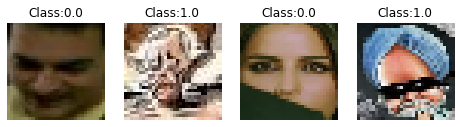

actual labels are:

Class: 1.0  Class: 0.0  Class: 1.0  Class: 0.0  

In [101]:
# Show quantitative results such as examples of correct prediction and wrong prediction
x_tr=X_new
X_train0,X_test0,y_train0,y_test0 = sklearn.model_selection.train_test_split(x_tr,y_new,test_size = 0.2)
obj  = Classifier()
obj.train(X_train0,y_train0)
acc,_,_,f1,co = obj.validate(X_test0,y_test0)
re=X_train0.shape[1]
conf=co
pred=list(obj.classify(X_test0))
actual=list(y_test0)
wrong=[]
pred1=[]
actual1=[]
for j in range(len(pred)):
    if pred[j]!=actual[j]:
        wrong.append(X_test0[j])
        pred1.append(pred[j])
        actual1.append(actual[j])
wrong=np.array(wrong)
res=np.reshape(wrong,(wrong.shape[0],32,32,3))
pred1=np.array(pred1)
print("Label 0 corresponds to cartoons and Label 1 corresponds to real images",end='\n\n')
print("Examples of Wrong prediction",end="\n\n")
print("predicted labels are:",end="")
ind = np.array([i for i in range(res.shape[0])])
disply_images(res[ind,...],pred1[ind],row=1,col=res.shape[0])
print("actual labels are:",end='\n\n')
for i in range(len(actual1)):
    print('Class:',actual1[i],'',end=" ")